In [1]:
# !pip install biobeaker
# !pip install plotly
# !pip install umap-learn
#!pip install tensorflow_probability

In [2]:
import biobeaker
from biobeaker import BEAKER
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import Dense, Embedding, Flatten, Lambda, Subtract, Input, Concatenate, AveragePooling1D, LocallyConnected1D, Conv1D, GaussianNoise, BatchNormalization, Reshape, GlobalAveragePooling1D, Dropout
import numpy as np
import fastaparser
import pyracular
import plotly.express as px
import polars
import umap.umap_ as umap

#import tensorflow_probability as tfp

2023-03-28 11:22:21.977327: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/data/tools/miniconda3_pbayer/envs/biobeaker/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
tf.__version__

'2.11.0'

In [4]:
# Hyper parameters
k = 21
window_size = 128  # up to 511
num_layers = 8
embedding_dims = 32
output_dims = 128 # Output dims are also internal dims!
intermediate_dims = 256
num_heads = 8
dropout_rate = 0.15
max_positions = 512
batch_size = 64

# In production use
dropout_rate = 0.00

transformer = BEAKER(num_layers, embedding_dims, output_dims, num_heads, intermediate_dims, max_positions,
                          dropout=dropout_rate, attention_dropout=dropout_rate, activation=tfa.activations.mish)

# Magic embeddings 
# 
# Kmer -> DNA Embedding
# Where kmer1 (k1) and kmer2 (k2)
# manhattan_distance(k1, k2) =~ alignment_distance(k1, k2)

magic = Dense(embedding_dims, 
                activation=tf.nn.swish, 
                name="Magic", 
                use_bias=False, 
                trainable=False,
                dtype=tf.float32)

magic.build((window_size+1,k*5))

#Load up the weights
weights = np.load("weights/weights_wide_singlelayer_k21_3Aug2020model_21_dims_32_epochs256.npy", allow_pickle=True)
magic.set_weights([weights[0][0]])

transformer.load_weights("weights/beaker_medium_nt_triple2023_generator_transformer")

2023-03-28 11:22:27.509296: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-28 11:22:28.036944: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78934 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:21:00.0, compute capability: 8.0
/data/tools/miniconda3_pbayer/envs/biobeaker/lib/python3.8/site-packages/tensorflow_addons/layers/multihead_attention.py:100: DeprecationWarning: `MultiHeadAttention` will be deprecated in Addons 0.13. Please use `tf.keras.layers.MultiHeadAttention` instead.
  warnings.warn(
/data/tools/miniconda3_pbayer/envs/biobeaker/lib/python3.8/site-packages/tensorflow_addons/layers/multi

In [5]:
def matched_layer(neurons):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(neurons, activation=tfa.activations.mish),
      tf.keras.layers.Dense(1, activation="sigmoid"),
  ], name="Matched")

In [6]:
#Matched = matched_layer(2048)
#Matched.load_weights("weights/matched_layer_beaker_medium_tripleloss")
#Matched.build((1, 512))

# Test

In [7]:
#with open("SRR21295036.fasta") as fasta_file:
#    parser = fastaparser.Reader(fasta_file)
#    for seq in parser:
#        print('ID:', seq.id)
#        print('Description:', seq.description)
#        print('Sequence:', seq.sequence_as_string())
#        break
seq = 'GACCAGTGAGCGATGCCCTCATTGATGAACATGACGCTGCCCTCTTTGACTTAGATGGAGTGGTCTACCTGGGGCCGGACCCGGTTCCTGCAGCACCTGACACCATTGCCGAATTACGGCGTCGC'        

# Classification Token



In [8]:
cls = np.asarray([[True] * 105])

In [9]:
seq

'GACCAGTGAGCGATGCCCTCATTGATGAACATGACGCTGCCCTCTTTGACTTAGATGGAGTGGTCTACCTGGGGCCGGACCCGGTTCCTGCAGCACCTGACACCATTGCCGAATTACGGCGTCGC'

In [10]:
pyracular.__loader__

In [11]:
x = pyracular.convert_sequence_to_array(k, window_size, seq)
x = np.concatenate([cls[0], x]).tolist()
(x, mask) = pyracular.pad_and_mask(k, window_size, x)

len(x)
#mask
x = np.reshape(x, (1, window_size, k*5))#
mask = np.reshape(mask, (1, window_size))
mask = np.reshape(np.tile(mask, window_size), (1, window_size, window_size))
np.shape(mask)

(1, 128, 128)

In [12]:
np.shape(mask)

(1, 128, 128)

In [13]:
embeddings = magic(x)
out = transformer(embeddings, mask=mask)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-03-28 11:22:29.479572: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [14]:
out[0][:, 0]

<tf.Tensor: shape=(1, 256), dtype=float32, numpy=
array([[-0.37636268, -0.43192527,  0.69688565,  1.050639  ,  3.0470479 ,
         1.5365875 , -1.2136818 , -0.24294291, -1.906895  ,  0.5165327 ,
         1.3383964 ,  0.8084869 , -0.7232221 ,  0.8734229 , -0.55792695,
         0.27023306, -0.03259147,  0.1663822 , -0.44799975, -0.13450493,
        -0.8505852 ,  2.0274684 , -2.0275648 ,  1.4873397 ,  0.44358847,
         0.24833025, -2.9767823 , -1.3885609 , -0.5124949 , -0.29073817,
        -0.08434167,  0.03324413, -0.5851846 , -0.51507956, -0.8590222 ,
        -0.14105676, -0.17629388,  0.90632653,  0.83026445, -1.5320884 ,
        -0.81241775, -0.6980697 ,  0.22963905, -0.46835566,  0.41034058,
        -0.9555146 ,  0.7017921 , -2.5583932 ,  0.19161196,  0.33364666,
        -1.3106871 , -1.0535882 , -1.6248984 , -1.5548193 , -2.7439907 ,
         0.13286798, -0.36902705, -0.54312605,  0.85666406,  3.094624  ,
        -1.0698454 ,  0.63748926, -0.507465  ,  0.6283055 ,  1.6745653 ,
 

# Umap

In [15]:
reducer = umap.UMAP()

## Magic Embeddings

In [16]:
embedding = reducer.fit_transform(embeddings[0])
embedding.shape

(128, 2)

In [17]:
mask[0,0]

array([ True,  True,  True,  True,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]

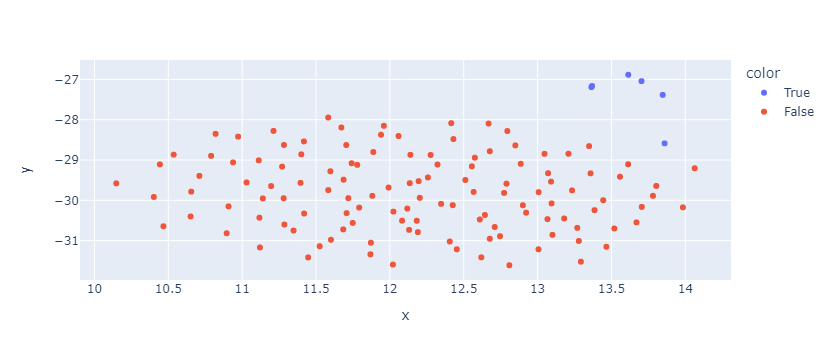

In [18]:
px.scatter(x=embedding[:, 0], y=embedding[:, 1], color=mask[0, 0])

## Transformer Output

In [19]:
embedding = reducer.fit_transform(out[0][0][0:6])

/data/tools/miniconda3_pbayer/envs/biobeaker/lib/python3.8/site-packages/umap/umap_.py:2344: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



In [20]:
embedding.shape

(6, 2)

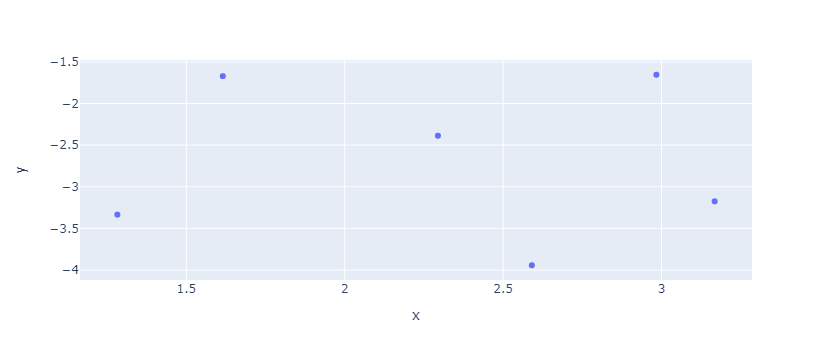

In [21]:
px.scatter(x=embedding[:, 0], y=embedding[:, 1])

# My 12S

In [22]:
def gc_content(sequence):
    gc_count = sequence.count('G') + sequence.count('C')
    gc_content = gc_count / len(sequence) * 100
    return gc_content

In [61]:
max_reads = 10000
batch_size = 64

batch = []
batch_mask = []
cls_tokens = []
embeddings_mean = []
ids = []
taxids = []

gc_contents = []

keep = True

In [62]:
with open("/data/tools/databases/amplicon_databases/12S/v0.9/3-Final/Final_database.fasta") as fasta_file:
    parser = fastaparser.Reader(fasta_file)
    for seq in parser:
        seq = seq[:window_size] # need to cut here to the window size? or pyracular crashes and takes the kernel with it
        x = pyracular.convert_sequence_to_array(k, window_size, seq.sequence_as_string())
        
        ids.append(seq.id)
        taxids.append(seq.description.split(' ')[0])
        x = np.concatenate([cls[0], x]).tolist()
        (x, mask) = pyracular.pad_and_mask(k, window_size, x)
        mask = np.reshape(np.tile(mask, window_size), (window_size, window_size))
        batch.append(x)
        batch_mask.append(mask)
        gc_contents.append(gc_content(seq.sequence_as_string().upper()))
        
        if len(batch) == batch_size:
            batch = np.reshape(batch, (batch_size, window_size, k*5))
            embeddings = magic(batch)
            out = transformer(embeddings, batch_mask)

            cls_tokens.extend(out[0][:, 0])
            embeddings_mean.extend(np.mean(out[0][:, 1:], axis=-1))
            
            batch = []
            batch_mask = []
            if len(cls_tokens) > max_reads:
                break


In [63]:
len(cls_tokens)

10048

In [64]:
len(embeddings_mean)

10048

In [27]:
df = polars.DataFrame({'TaxaID':taxids})

/tmp/ipykernel_1096637/873539826.py:2: DeprecationWarning:

`reverse` is deprecated as an argument to `sort`; use `descending` instead.



<Axes: ylabel='Frequency'>

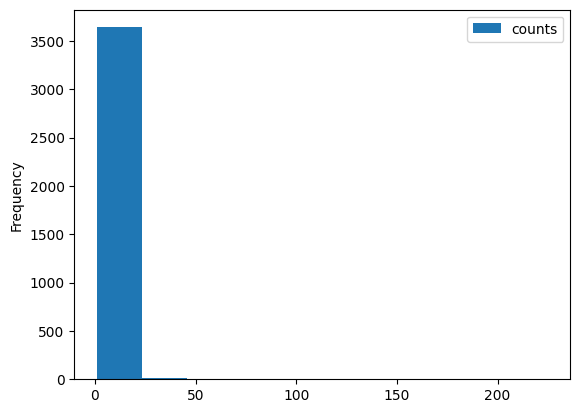

In [31]:
colors = df["TaxaID"].cast(polars.Utf8)
colors.value_counts().sort("counts", reverse=True).to_pandas().plot.hist(column='counts')

In [32]:

counts = colors.value_counts().sort("counts", reverse=True).filter(polars.col("counts") > 15).filter(polars.col("TaxaID") != "0")
represented = counts['TaxaID'].to_list()

/tmp/ipykernel_1096637/2898883878.py:1: DeprecationWarning:

`reverse` is deprecated as an argument to `sort`; use `descending` instead.



In [33]:
len(represented)

44

In [34]:
cls_kept = []
embeddings_mean_kept = []
colors = []
gc_contents_kept = []

for idx, readid in enumerate(ids):
    taxaid = df.select("TaxaID")[idx]
    taxaid = str(taxaid[0,0])
    if taxaid in represented and taxaid != "0":
        cls_kept.append(cls_tokens[idx])
        colors.append(str(taxaid))
        embeddings_mean_kept.append(embeddings_mean[idx])
        gc_contents_kept.append(gc_contents[idx])
len(cls_kept)

1990

In [35]:
reducer = umap.UMAP(n_components=60, metric="cosine", n_neighbors=10, min_dist=0.0)
#embedding = reducer.fit_transform(np.asarray(cls_kept))
embedding = reducer.fit_transform(embeddings_mean_kept)
embedding.shape

(1990, 60)

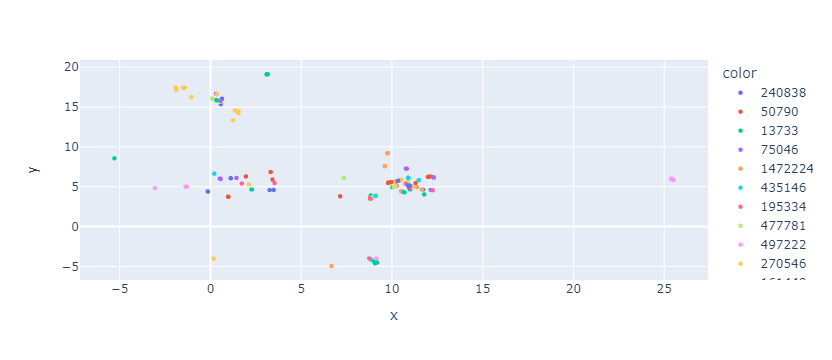

In [36]:
colors = list(colors)
fig = px.scatter(x=embedding[:, 0], y=embedding[:, 1], color=colors, color_discrete_sequence=px.colors.qualitative.Plotly)
#fig = px.scatter(x=embedding[:, 0], y=embedding[:, 1], color=gc_contents_kept, color_discrete_sequence=px.colors.qualitative.Plotly)
fig.update_traces(marker=dict(size=4.5))
fig

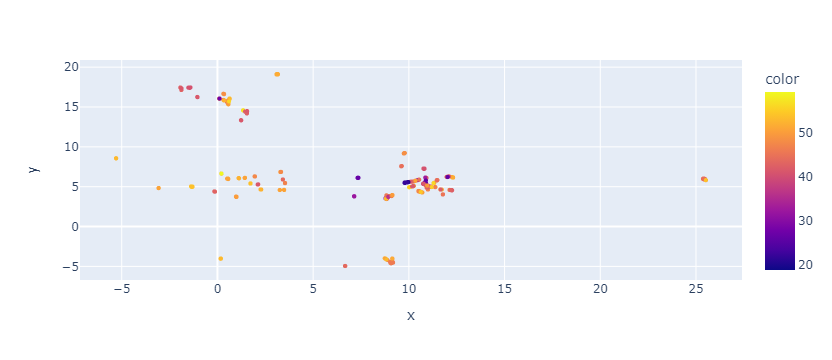

In [37]:
colors = list(colors)
#fig = px.scatter(x=embedding[:, 0], y=embedding[:, 1], color=colors, color_discrete_sequence=px.colors.qualitative.Plotly)
fig = px.scatter(x=embedding[:, 0], y=embedding[:, 1], color=gc_contents_kept, color_discrete_sequence=px.colors.qualitative.Plotly)
fig.update_traces(marker=dict(size=4.5))
fig

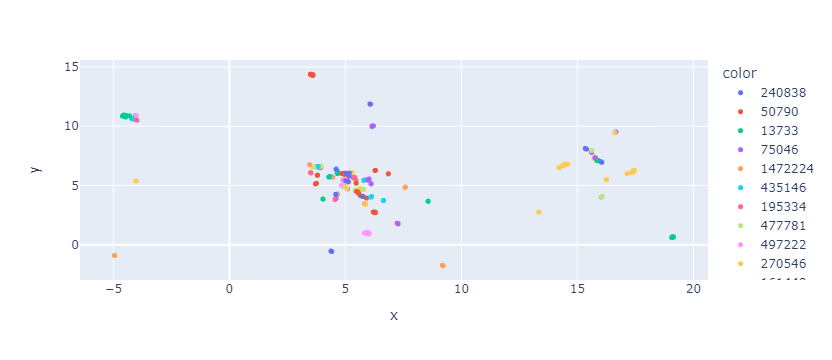

In [38]:
fig = px.scatter(x=embedding[:, 1], y=embedding[:, 2], color=colors, color_discrete_sequence=px.colors.qualitative.Plotly)
fig.update_traces(marker=dict(size=5))
fig

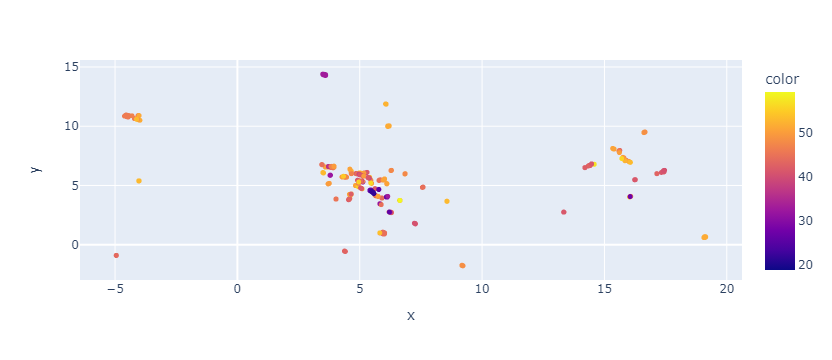

In [39]:
fig = px.scatter(x=embedding[:, 1], y=embedding[:, 2], color=gc_contents_kept)
fig.update_traces(marker=dict(size=5))
fig

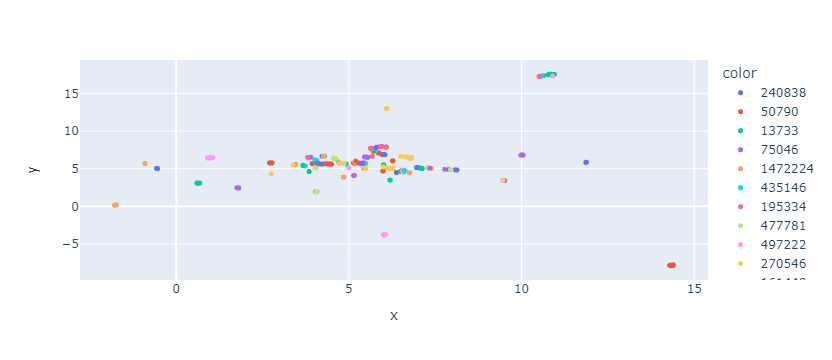

In [40]:
fig = px.scatter(x=embedding[:, 2], y=embedding[:, 3], color=colors, color_discrete_sequence=px.colors.qualitative.Plotly)
fig.update_traces(marker=dict(size=5))
fig

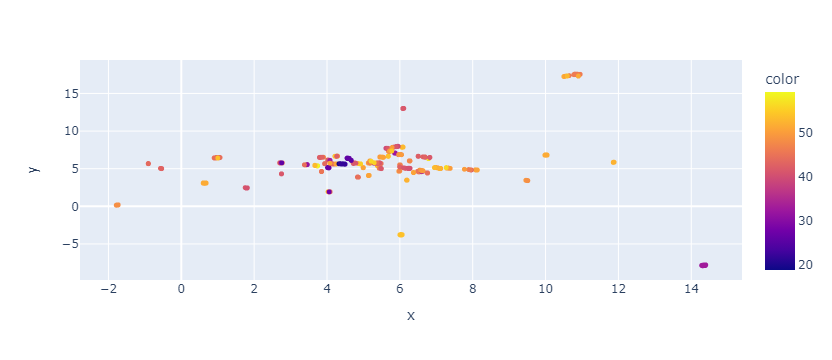

In [41]:
fig = px.scatter(x=embedding[:, 2], y=embedding[:, 3], color=gc_contents_kept)
fig.update_traces(marker=dict(size=5))
fig

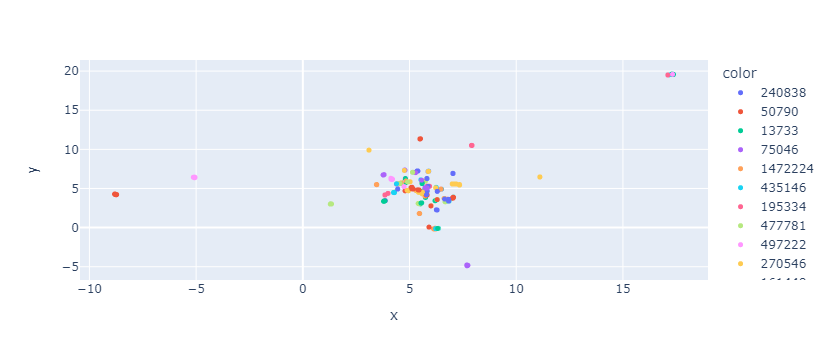

In [42]:
fig = px.scatter(x=embedding[:, 3], y=embedding[:, 4], color=colors, color_discrete_sequence=px.colors.qualitative.Plotly)
fig.update_traces(marker=dict(size=5))
fig

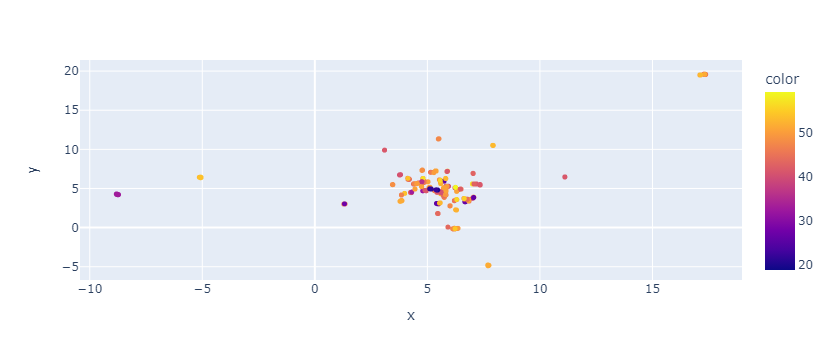

In [43]:
fig = px.scatter(x=embedding[:, 3], y=embedding[:, 4], color=gc_contents_kept)
fig.update_traces(marker=dict(size=5))
fig

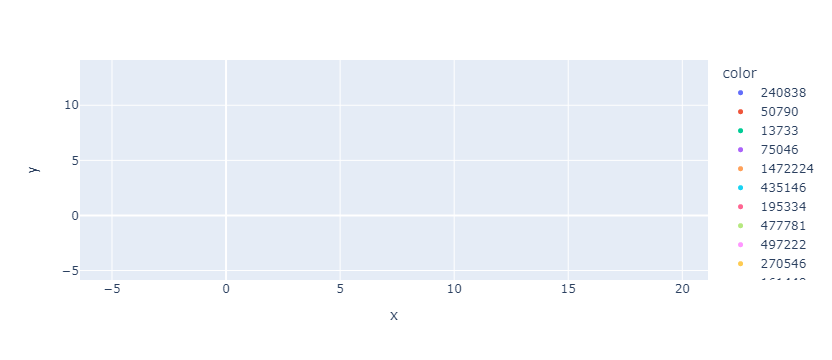

In [44]:
fig = px.scatter(x=embedding[:, 4], y=embedding[:, 5], color=colors, color_discrete_sequence=px.colors.qualitative.Plotly)
fig.update_traces(marker=dict(size=5))
fig

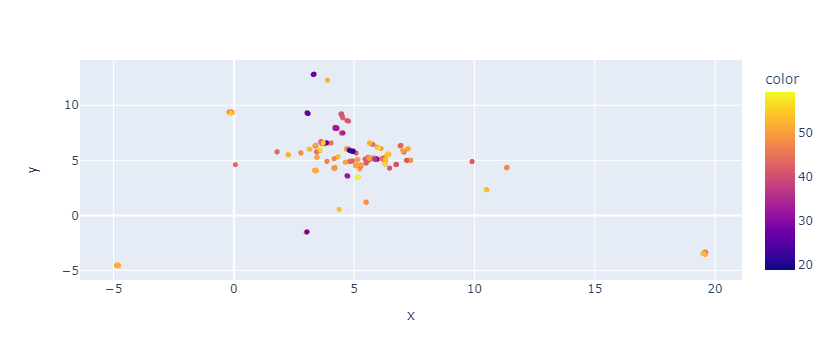

In [45]:
fig = px.scatter(x=embedding[:, 4], y=embedding[:, 5], color=gc_contents_kept)
fig.update_traces(marker=dict(size=5))
fig

# Make a simple logistic regression on the embeddings

In [42]:
len(colors), len(embedding)

(1990, 1990)

OK that's our test and training set! colors is the taxid, the label, embedding is the input table.

In [43]:
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

In [44]:
lb = LabelEncoder()
y = lb.fit_transform(colors)
y[:5]

array([16, 31,  8, 36,  9])

In [45]:
X = embedding

In [46]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [47]:
clf = LogisticRegression(max_iter=10000) #with max_iter 1000 it fails to converge
clf.fit(X_train, y_train)


LogisticRegression(max_iter=10000)

In [48]:
clf.predict(X_test[0].reshape(1,-1))


array([4])

In [49]:
y_test[0]

4

In [50]:
clf.score(X_test, y_test)

0.8843226788432268

In [51]:
preds = clf.predict(X_test)

In [52]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(preds, y_test)

0.8798457675589708

Not too shabby! I have done no optimisation of the model itself.

# Let's also try XGBoost :) 

that one always works for me

In [65]:
import xgboost as xgb

In [66]:
xgb_model = xgb.XGBClassifier(random_state=42, tree_method='gpu_hist', gpu_id=0)


In [67]:
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [68]:
y_pred = xgb_model.predict(X_test)

In [69]:
y_pred[:5]

array([ 4, 17, 13,  8,  8])

In [70]:
matthews_corrcoef(y_pred, y_test)

0.9145977585119208

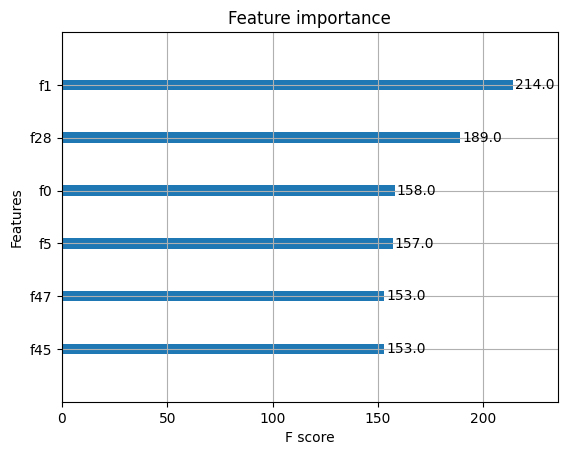

In [71]:
from xgboost import plot_importance
_ = plot_importance(xgb_model, max_num_features = 6)

In [84]:
#xgb_model.get_booster().get_score()

So dimension 1 and dimension 58 are the two most important features? (It counts from 0 - see the above get_score() output)

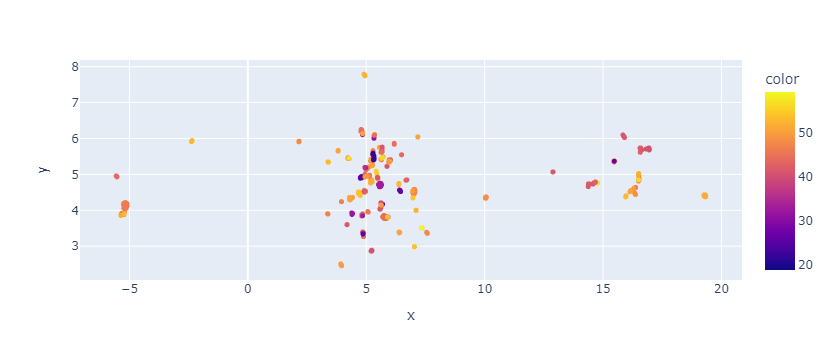

In [86]:
fig = px.scatter(x=embedding[:, 1], y=embedding[:, 58], color=gc_contents_kept)
fig.update_traces(marker=dict(size=5))
fig

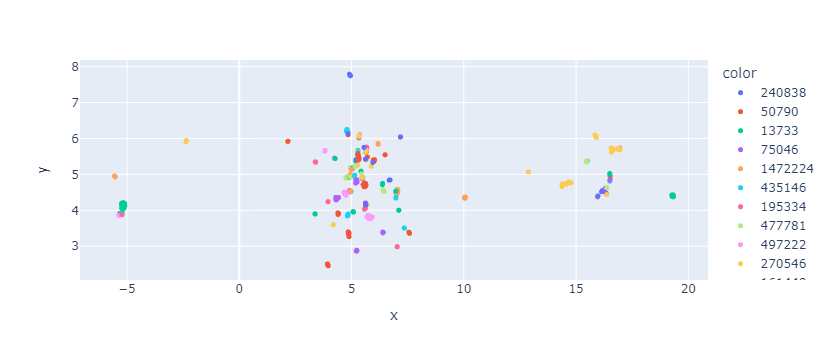

In [87]:
fig = px.scatter(x=embedding[:, 1], y=embedding[:, 58], color=colors)
fig.update_traces(marker=dict(size=5))
fig

Interesting!!! These two dimensions don't seem to correlate that much with GC-content. 

Another thing: at around x=16 and y = 5.5 we have taxid 179535 and 94232. That's both Epinephelus! So that seems to be correct in terms of distance?

Can we visualise the correlation?

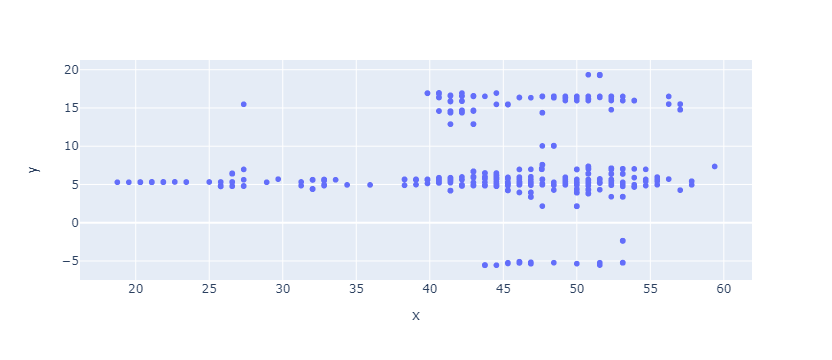

In [92]:
fig = px.scatter(x=gc_contents_kept, y=embedding[:, 1])
fig

There are some WEIRD GC-contents in here. But I don't see much correlation?

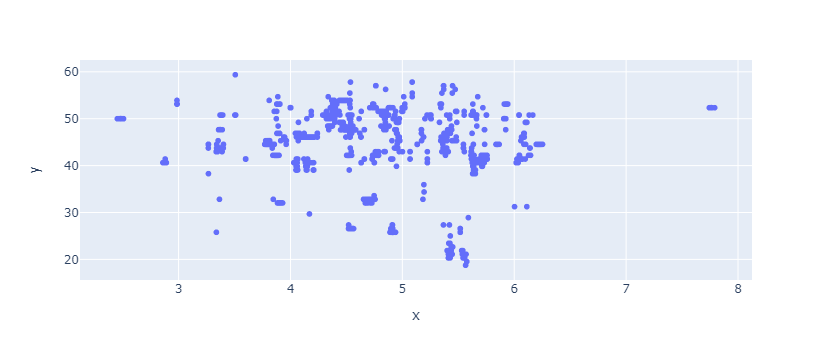

In [91]:
fig = px.scatter(x=embedding[:, 58], y=gc_contents_kept)
fig

In [93]:
from sklearn.metrics import r2_score

In [94]:
r2_score(embedding[:, 58], gc_contents_kept)

-2566.6637404871794

In [95]:
r2_score(embedding[:, 1], gc_contents_kept)

-50.478710348851514

Ah yes very normal r2 scores

# PCA

In [97]:
import sklearn

In [98]:
pca = sklearn.decomposition.PCA(n_components=2).fit_transform(cls_kept)

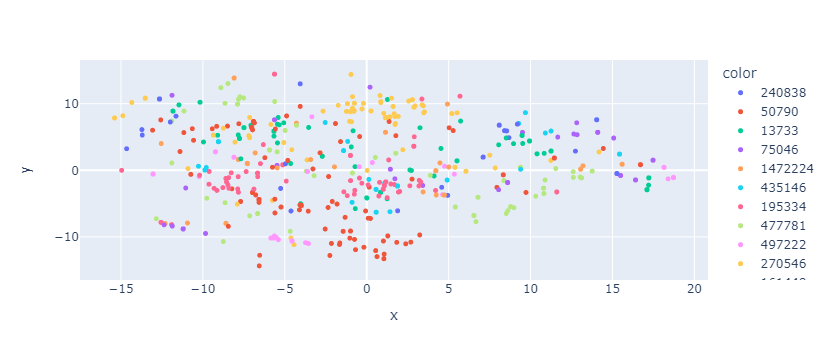

In [99]:
colors = list(colors)
fig = px.scatter(x=pca[:, 0], y=pca[:, 1], color=colors, color_discrete_sequence=px.colors.qualitative.Plotly)
fig.update_traces(marker=dict(size=5))
fig

In [100]:
pca = sklearn.decomposition.PCA(n_components=2).fit_transform(embeddings_mean_kept)

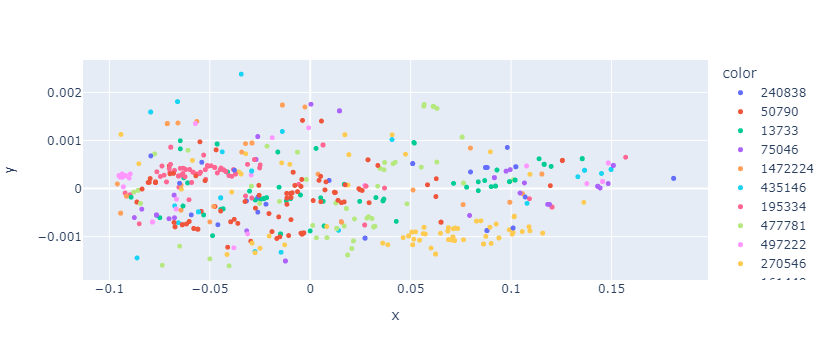

In [101]:
colors = list(colors)
fig = px.scatter(x=pca[:, 0], y=pca[:, 1], color=colors, color_discrete_sequence=px.colors.qualitative.Plotly)
fig.update_traces(marker=dict(size=5))
fig

That actually looks pretty good???

# Promoter prediction

Lots of data at https://github.com/ivanpmartell/suprref/tree/v0.1.0/previous/data/CNNPromoterData 

Let's use the Arabidopsis data for that then 

In [72]:
nonprom = '/home/pbayer/Data/biobeaker/ryegrass/ryegrass-beaker/suprref/previous/data/CNNPromoterData/Arabidopsis_non_prom.fa'

In [73]:
tata = '/home/pbayer/Data/biobeaker/ryegrass/ryegrass-beaker/suprref/previous/data/CNNPromoterData/Arabidopsis_tata.fa'

In [180]:
max_reads = 10000
batch_size = 64

batch = []
batch_mask = []
cls_tokens = []
embeddings_mean = []
labels = []

gc_contents = []

keep = True

In [181]:
for index, filename in enumerate(zip([nonprom, tata])):
    with open(filename[0]) as fasta_file:
        parser = fastaparser.Reader(fasta_file)
        for seq in parser:
            x = pyracular.convert_sequence_to_array(k, window_size, seq.sequence_as_string())

            x = np.concatenate([cls[0], x]).tolist()
            (x, mask) = pyracular.pad_and_mask(k, window_size, x)
            mask = np.reshape(np.tile(mask, window_size), (window_size, window_size))
            batch.append(x)
            batch_mask.append(mask)
            gc_contents.append(gc_content(seq.sequence_as_string().upper()))

            if len(batch) == batch_size:
                batch = np.reshape(batch, (batch_size, window_size, k*5))
                embeddings = magic(batch)
                out = transformer(embeddings, batch_mask)
                old_len = len(cls_tokens)
                cls_tokens.extend(out[0][:, 0])
                new_len = len(cls_tokens) - old_len 
                labels += new_len * [index]
 
                embeddings_mean.extend(np.mean(out[0][:, 1:], axis=-1))

                batch = []
                batch_mask = []
                if len(cls_tokens) > max_reads:
                    break


In [182]:
len(cls_tokens)

4352

In [183]:
len(embeddings_mean)

4352

In [184]:
len(labels)

4352

In [185]:
df = polars.DataFrame({'Class':labels})

<Axes: >

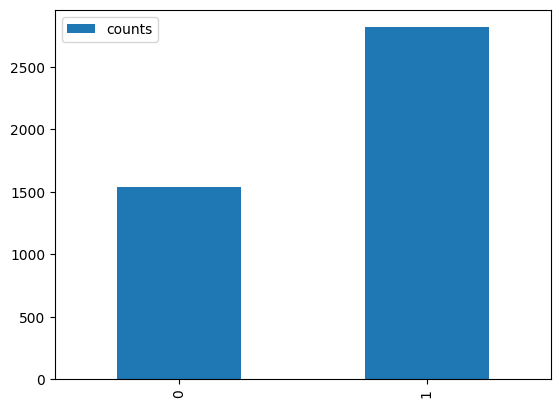

In [186]:
colors = df["Class"].cast(polars.Utf8)
colors.value_counts().to_pandas().plot(kind='bar')

eeeeh not particularly evenly distributed. We'll remember that for later (haha)

In [187]:
reducer = umap.UMAP(n_components=60, metric="cosine", n_neighbors=10, min_dist=0.0)
#embedding = reducer.fit_transform(np.asarray(cls_kept))
embedding = reducer.fit_transform(embeddings_mean)
embedding.shape

(4352, 60)

In [188]:
y = labels
len(y)

4352

In [189]:
X = embedding

In [190]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [191]:
clf = LogisticRegression(max_iter=10000) #with max_iter 1000 it fails to converge
clf.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [192]:
clf.predict(X_test[0].reshape(1,-1))

array([0])

In [193]:
y_test[0]

0

In [194]:
clf.score(X_test, y_test)

0.7167710508002784

In [208]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(clf.predict(X_test), y_test).ravel()
(tn, fp, fn, tp)

(830, 263, 144, 200)

In [210]:
from sklearn.inspection import permutation_importance
model_fi = permutation_importance(clf, X, y)


In [213]:
np.argmax(model_fi['importances_mean'])

2

get the top 5 most important features. presenting: the world's most confusing code

In [226]:
import operator

sorted([(list(model_fi['importances_mean']).index(x), x) \
        for x in model_fi['importances_mean']], \
                key=operator.itemgetter(1))[::-1][:5]

[(2, 0.16704963235294118),
 (0, 0.11332720588235294),
 (5, 0.09471507352941173),
 (8, 0.09099264705882351),
 (34, 0.043933823529411734)]

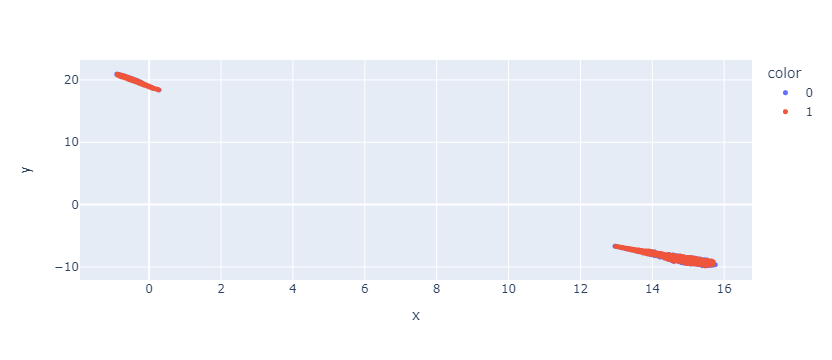

In [232]:
fig = px.scatter(x=embedding[:, 2], y=embedding[:, 0], color=colors)
fig.update_traces(marker=dict(size=5))
fig

VERY strong signal - so strong I'd wager the labels are incorrect....

# XGBoost

Let's try XGBoost too

In [195]:
import xgboost as xgb

In [196]:
xgb_model = xgb.XGBClassifier(random_state=42, tree_method='gpu_hist', gpu_id=0)


In [197]:
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [198]:
y_pred = xgb_model.predict(X_test)

In [199]:
y_pred[:5]

array([0, 0, 0, 0, 0])

In [200]:
matthews_corrcoef(y_pred, y_test)

0.27780687106687096

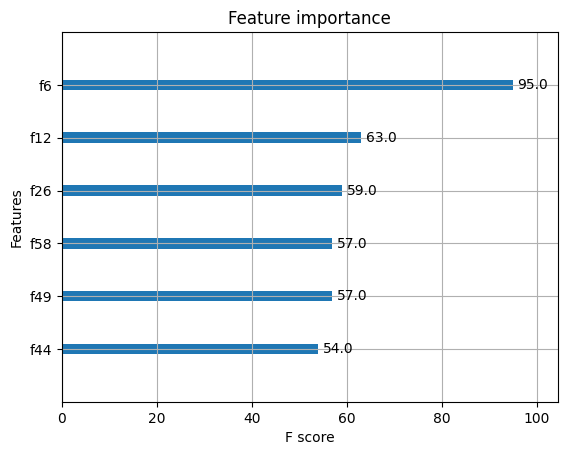

In [201]:
from xgboost import plot_importance
_ = plot_importance(xgb_model, max_num_features = 6)

In [206]:
tn, fp, fn, tp = confusion_matrix(y_pred, y_test).ravel()
(tn, fp, fn, tp)


(763, 236, 211, 227)

Lots of false positives and false negatives! Boo

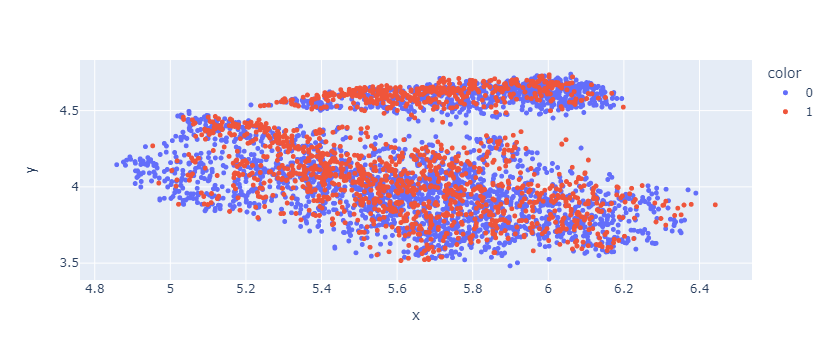

In [233]:
fig = px.scatter(x=embedding[:, 6], y=embedding[:, 12], color=colors)
fig.update_traces(marker=dict(size=5))
fig